# Supplementary Figures

Here are the supplementary plots that show summary statistics for the developmental signaling pathways we studied.

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
from matplotlib import pyplot as plt
import itertools
from natsort import natsorted

import logging

from rpy2.robjects import pandas2ri
import rpy2.rinterface_lib.callbacks

# Ignore R warning messages
# Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
%load_ext rpy2.ipython

In [2]:
%%R
library(ggplot2)
library(dplyr)
library(RColorBrewer)
library(ggplot2)
library(pheatmap)
library(corrplot)

In [3]:
# Set directories for the data, results, and figures. SPECIFY AS APPROPRIATE
datadir = "./alejo_metadata/data/"
figdir = "./alejo_metadata/figures/own_norm/"

In [4]:
# Load datasets
df = pd.read_csv(datadir + "fig_version_countsSeurat_Apr22.csv")
df.index = df["Unnamed: 0"]
df = df.drop(columns = ["Unnamed: 0"]).T
df.index = range(df.shape[0])

meta = pd.read_csv(datadir + "meta_data_Aug2021.csv")
pathways = pd.read_csv(datadir + "pathway_list.csv")

integrated_counts = np.log1p(df.div(df.sum(axis=1),axis=0)*1e4)
integrated_counts["cell_id"] = meta["cell_id"]
integrated_counts["Cell_class"] = meta["Cell_class"]

## BMP Plots

In [5]:
pathway_genes = list(pathways[pathways["pathway"] == "Bmp_Tgfb"]["gene"].values)

bmpr_type_one = [i for i in pathway_genes if "1" in i]
bmpr_type_two = [i for i in pathway_genes if "2" in i]

In [6]:
# returns a clipped matrix given a list of max values for each gene 
def quantile_saturation(x = [], gene_quantiles = []):
    x_clipped = pd.DataFrame() 
    # saturate the values based on 99 quantile (more robust than using the abs max)
    for i in range(x.shape[0]):
        x_clipped =  x_clipped.append(np.clip(x.loc[i], a_min=0, a_max = gene_quantiles))

    # data frame is ordered alphabetically now! 
    # re-order columns 
    x_clipped = x_clipped[pathway_genes]
    return x_clipped

In [7]:
x = integrated_counts[pathway_genes]
gene_quantiles = np.quantile(x, q = 0.99, axis = 0)
gene_quantiles

array([0.6479557 , 0.18002621, 0.25736951, 2.93646707, 0.13878231,
       1.40742312, 0.12676333, 0.25010991, 0.79945611, 0.52143755,
       1.41746631])

In [8]:
# saturated matrix  by 0.99 quantile to avoid problem with outliers in min.max 
x_clipped = quantile_saturation(x, gene_quantiles)
x_clipped.describe() 

,Bmpr1a,Bmpr1b,Acvr1,Acvrl1,Acvr1b,Tgfbr1,Acvr1c,Acvr2a,Acvr2b,Bmpr2,Tgfbr2
count,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000
mean,0.174746,0.010185,0.047448,0.207868,0.019365,0.204041,0.003809,0.056347,0.171019,0.077264,0.253857
std,0.167259,0.028057,0.056113,0.451051,0.027337,0.216681,0.017101,0.052769,0.227145,0.110175,0.319152
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.024696,0.000000,0.007072,0.003779,0.000000,0.071994,0.000000,0.016728,0.008508,0.009665,0.010673
50%,0.128166,0.000000,0.026510,0.023229,0.007058,0.136030,0.000000,0.041313,0.051766,0.033868,0.129044
75%,0.280556,0.006436,0.065708,0.172660,0.028376,0.275623,0.000077,0.078793,0.256899,0.088366,0.376579
max,0.647956,0.180026,0.257370,2.936467,0.138782,1.407423,0.126763,0.250110,0.799456,0.521438,1.417466


In [9]:
from sklearn.preprocessing import MinMaxScaler
# min max after saturation
scaler= MinMaxScaler() 
scaler.fit(x_clipped)
# max value for each gene = 1
df_clip = pd.DataFrame(scaler.transform(x_clipped), columns = pathway_genes)
df_clip['cell_id'] = integrated_counts['cell_id']
df_clip['Cell_class'] = integrated_counts['Cell_class']

In [10]:
df_clip['ON'] = np.sum(df_clip[pathway_genes].values > 0.2, axis = 1)>2

# pathway_mat is the final data.frame we are using 
pathway_mat = df_clip[df_clip['ON']]

In [11]:
pathway_mat.shape #same number of cells as in manuscript -- same filtering parameters and scaler 

(622, 14)

In [12]:
df_clip.head()

,Bmpr1a,Bmpr1b,Acvr1,Acvrl1,Acvr1b,Tgfbr1,Acvr1c,Acvr2a,Acvr2b,Bmpr2,Tgfbr2,cell_id,Cell_class,ON
0,0.400400,0.052337,0.154991,0.001123,0.394376,0.075130,0.0,0.117825,0.576148,0.195752,0.001067,1_E6.5_8.5_Chan,Epiblast,True
1,0.127450,0.042669,0.036343,0.000000,0.039646,0.020807,0.0,0.046493,0.159978,0.012652,0.000000,2_E6.5_8.5_Chan,Ectoderm,False
2,0.453898,0.076784,0.123388,0.000000,0.458279,0.070510,0.0,0.148989,0.629725,0.115875,0.003820,3_E6.5_8.5_Chan,Epiblast,True
3,0.416087,0.057867,0.131791,0.000000,0.419273,0.093093,0.0,0.136184,0.639157,0.157825,0.003999,4_E6.5_8.5_Chan,Epiblast,True
4,0.225643,0.000000,0.052509,0.006353,0.467789,0.043515,0.0,0.271386,0.407170,0.081013,0.014628,5_E6.5_8.5_Chan,Ex_ectoderm,True


### BMPR Counts

In [13]:
bmpr_df = df_clip[pathway_genes]

bmpr_count_df = pd.DataFrame((bmpr_df > 0.2).apply(np.count_nonzero), columns = ["counts"])

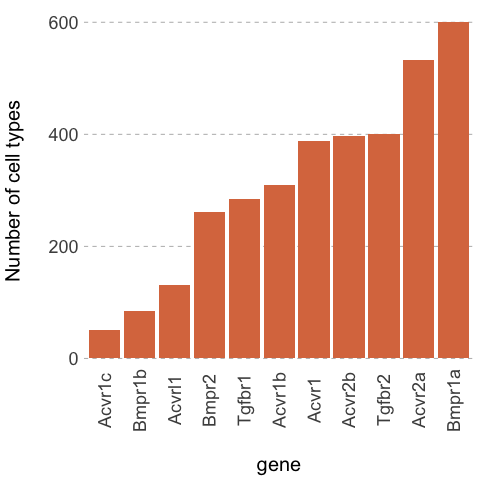

In [14]:
%%R -i bmpr_count_df
p <- ggplot(data = bmpr_count_df, aes(x = reorder(rownames(bmpr_count_df), counts), y = counts)) + 
     geom_hline(yintercept = 0, colour = "grey", linetype = "dashed") + 
     geom_hline(yintercept = 200, colour = "grey", linetype = "dashed") + 
     geom_hline(yintercept = 400, colour = "grey", linetype = "dashed") +
     geom_hline(yintercept = 600, colour = "grey", linetype = "dashed") + 
     geom_bar(stat="identity", fill = "#DB784D") +
     labs(x = "gene", y = "Number of cell types") + 
     theme(axis.title.x = element_text(size = 20, margin = margin(t = 25)),
           axis.text.x = element_text(angle = 90, size = 18, vjust = 0.5, margin = margin(t = -10)), 
           axis.ticks.x = element_blank(),
           axis.title.y = element_text(size = 20, margin = margin(r = 25)),
           axis.text.y = element_text(size = 18),
           axis.ticks.y = element_blank(),
           panel.border = element_blank(), 
           panel.grid.major = element_blank(),
           panel.grid.minor = element_blank(), 
           panel.background = element_blank())
    
ggsave("./alejo_metadata/figures/own_norm/Figure_3_figure_supplement_1A.pdf")
p

### Co-Expression Heatmap of BMP Receptors

In [15]:
arrays = [
    np.repeat(pathway_genes, len(pathway_genes)),
    np.array(pathway_genes*len(pathway_genes))
]

coexp_df = pd.DataFrame(columns = arrays)

for i in pathway_genes:
    for j in pathway_genes:
        coexp_df[(i, j)] = np.where((bmpr_df[i] >= 0.1) & (bmpr_df[j] >= 0.2), 1, 0)
    
coexp_df = coexp_df.sum(axis = 0).unstack(level = 0)#.unstack().reset_index()

gene_order = bmpr_type_one+bmpr_type_two

coexp_df = coexp_df.loc[gene_order][gene_order]

In [16]:
%%R -i coexp_df

pheatmap(coexp_df, #treeheight_row = 20,treeheight_col = 20,
         color = rev(colorRampPalette(rev(brewer.pal(n = 7, name ="Greys")))(100)),
         fontsize =12,angle_col = 45, cluster_rows = F, cluster_cols = F,
         filename = "./alejo_metadata/figures/own_norm/Figure_3_figure_supplement_1C.1.pdf",
         breaks = seq(0, max(coexp_df), length.out = 100),
         cellwidth = 22, cellheight = 22, 
         height = 4, width = 6)

### Bmp-Tgfbr ECDF Plots

In [17]:
bmpr_count_df = pd.DataFrame(index = bmpr_df.index)

min_exp = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

for i in min_exp:
    bmpr_count_df[str(i)] = (bmpr_df.T > i).apply(np.count_nonzero)

bmpr_count_df = bmpr_count_df.melt(var_name = "prob")

bmpr_count_df.head()

,prob,value
0,0.05,8
1,0.05,2
2,0.05,8
3,0.05,8
4,0.05,6


In [18]:
bmpr_ecdf = pd.DataFrame(columns = ["prob", "value", "ecdf"])

for i in bmpr_count_df["prob"].unique():
    
    subset_df = bmpr_count_df[bmpr_count_df["prob"] == i]
    
    for j in range(min(bmpr_count_df["value"]), max(bmpr_count_df["value"] + 1)):

        ecdf_val = len(subset_df[subset_df["value"] <= j]["value"])/len(subset_df["value"])
        
        new_row = pd.DataFrame([[i, j, ecdf_val]], columns = ["prob", "value", "ecdf"])
                
        bmpr_ecdf = pd.concat([bmpr_ecdf, new_row])
        
bmpr_ecdf.head()

,prob,value,ecdf
0,0.05,0,0.019900
0,0.05,1,0.058043
0,0.05,2,0.131012
0,0.05,3,0.208955
0,0.05,4,0.309287


In [19]:
%%R -i bmpr_ecdf

xrange <- c(0,11)
yrange <- c(0.0,1.0)

colors <- c("#e6f5c9", "#2078b4", "#e5c494", "#beb9da", "#6a3d9a", "#fef2ae")


pdf("./alejo_metadata/figures/own_norm/Figure_3_figure_supplement_1B.pdf", useDingbats=FALSE)
par(mar=c(5,6,4,1)+.1, cex.axis = 1.5)

plot(xrange, yrange, type = "n", xlab="Number of receptors", ylab="ECDF",
    main = "Number of receptors expressed across cell types",
    cex.lab=1.5, cex.main=1.5, cex.sub=1.5)
axis(side=2, at=c(0:11), labels = 0:11)


for (i in 1:length(unique(bmpr_ecdf$prob))){
    xvals <- bmpr_ecdf$value[bmpr_ecdf$prob == unique(bmpr_ecdf$prob)[i]]
    yvals <- bmpr_ecdf$ecdf[bmpr_ecdf$prob == unique(bmpr_ecdf$prob)[i]]
    colvals <- colors[i]
    
    lines(xvals[order(xvals)], yvals[order(xvals)], col = colvals, lwd = 4)
    points(xvals[order(xvals)], yvals[order(xvals)], col = colvals, pch = 1, cex = 1.5, lwd = 4)
}

legend("bottomright", inset=.02, title="Min exp",
   c("0.05", "0.1", "0.2", "0.3", "0.4", "0.5"), fill=colors, horiz=FALSE, cex=1.5)

dev.off()

[1] 2


## Notch

In [20]:
pathway_genes = list(pathways[pathways["pathway"] == "Notch"]["gene"].values)

In [21]:
x = integrated_counts[pathway_genes]
gene_quantiles = np.quantile(x, q= 0.99, axis = 0)
gene_quantiles

array([0.67206619, 0.94620692, 0.82279945, 1.47107506, 0.29903521,
       1.567202  , 1.28785308, 1.77019097, 0.60596418, 0.85384788,
       0.34605149, 1.16790551])

In [22]:
# saturated matrix  by 0.99 quantile to avoid problem with outliers in min.max 
x_clipped = quantile_saturation(x, gene_quantiles)
x_clipped.describe() 

,Dll1,Dll3,Dll4,Jag1,Jag2,Notch1,Notch2,Notch3,Notch4,Mfng,Rfng,Lfng
count,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000
mean,0.045711,0.037356,0.047563,0.132162,0.020159,0.254916,0.270746,0.085560,0.048047,0.114217,0.115788,0.165934
std,0.105058,0.130356,0.149868,0.244890,0.050763,0.327232,0.277195,0.250395,0.109029,0.172868,0.070568,0.264093
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.005869,0.000000,0.050362,0.058762,0.000263,0.003831,0.002875,0.067396,0.009333
50%,0.007271,0.000000,0.000660,0.033716,0.002129,0.132765,0.166685,0.014431,0.014120,0.030390,0.097068,0.040172
75%,0.036400,0.016172,0.008880,0.140159,0.010000,0.301811,0.406283,0.066928,0.036206,0.178138,0.151794,0.181560
max,0.672066,0.946207,0.822799,1.471075,0.299035,1.567202,1.287853,1.770191,0.605964,0.853848,0.346051,1.167906


In [23]:
from sklearn.preprocessing import MinMaxScaler
# min max after saturation
scaler= MinMaxScaler() 
scaler.fit(x_clipped)
# max value for each gene = 1
df_clip = pd.DataFrame(scaler.transform(x_clipped), columns = pathway_genes)
df_clip['cell_id'] = integrated_counts['cell_id']
df_clip['Cell_class'] = integrated_counts['Cell_class']

In [24]:
df_clip['ON'] = np.sum(df_clip[pathway_genes].values>0.2, axis =1)>2

# pathway_mat is the final data.frame we are using 
pathway_mat = df_clip[df_clip['ON']]

In [25]:
df_clip.head()

,Dll1,Dll3,Dll4,Jag1,Jag2,Notch1,Notch2,Notch3,Notch4,Mfng,Rfng,Lfng,cell_id,Cell_class,ON
0,0.014819,0.136275,0.000000,0.041043,0.016864,0.046589,0.062934,0.064582,0.114331,0.026468,0.236436,0.015711,1_E6.5_8.5_Chan,Epiblast,False
1,0.000000,0.068862,0.000000,0.005510,0.000000,0.001764,0.009885,0.008756,0.071154,0.034318,0.182304,0.000000,2_E6.5_8.5_Chan,Ectoderm,False
2,0.010974,0.073606,0.000000,0.040344,0.000000,0.036166,0.429603,0.062882,0.062029,0.063305,0.188277,0.025875,3_E6.5_8.5_Chan,Epiblast,False
3,0.006131,0.088485,0.002994,0.008539,0.007506,0.032810,0.032471,0.059412,0.101778,0.073151,0.238092,0.027696,4_E6.5_8.5_Chan,Epiblast,False
4,0.001608,0.057720,0.000000,0.001342,0.033267,0.015496,0.037971,0.001749,0.160801,0.007979,0.429918,0.001190,5_E6.5_8.5_Chan,Ex_ectoderm,False


### Notch Counts

In [26]:
notch_df = df_clip[pathway_genes]

notch_count_df = pd.DataFrame((notch_df > 0.2).apply(np.count_nonzero), columns = ["counts"])

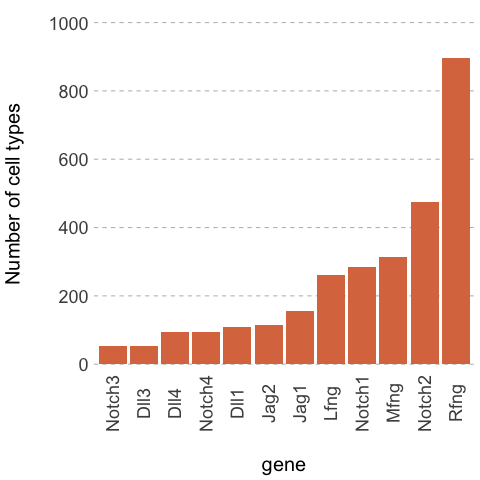

In [27]:
%%R -i notch_count_df
p <- ggplot(data = notch_count_df, aes(x = reorder(rownames(notch_count_df), counts), y = counts)) + 
     geom_hline(yintercept = 0, colour = "grey", linetype = "dashed") + 
     geom_hline(yintercept = 200, colour = "grey", linetype = "dashed") + 
     geom_hline(yintercept = 400, colour = "grey", linetype = "dashed") +
     geom_hline(yintercept = 600, colour = "grey", linetype = "dashed") + 
     geom_hline(yintercept = 800, colour = "grey", linetype = "dashed") + 
     geom_hline(yintercept = 1000, colour = "grey", linetype = "dashed") + 
     scale_y_continuous(breaks = seq(0, 1000, 200), labels = c("0", "200", "400", "600", "800", "1000"))+
     geom_bar(stat="identity", fill = "#DB784D") +
     labs(x = "gene", y = "Number of cell types") + 
     theme(axis.title.x = element_text(size = 20, margin = margin(t = 25)),
           axis.text.x = element_text(angle = 90, size = 18, vjust = 0.5, margin = margin(t = -10)), 
           axis.ticks.x = element_blank(),
           axis.title.y = element_text(size = 20, margin = margin(r = 25)),
           axis.text.y = element_text(size = 18),
           axis.ticks.y = element_blank(),
           panel.border = element_blank(), 
           panel.grid.major = element_blank(),
           panel.grid.minor = element_blank(), 
           panel.background = element_blank())
ggsave("./alejo_metadata/figures/own_norm/Figure_5_figure_supplement_3A_left.pdf")
p

### Co-Expression Heatmap of Notch

In [28]:
arrays = [
    np.repeat(pathway_genes, len(pathway_genes)),
    np.array(pathway_genes*len(pathway_genes))
]

coexp_df = pd.DataFrame(columns = arrays)

for i in pathway_genes:
    for j in pathway_genes:
        coexp_df[(i, j)] = np.where((notch_df[i] >= 0.2) & (notch_df[j] >= 0.2), 1, 0)
    
coexp_df = coexp_df.sum(axis = 0).unstack(level = 0)#.unstack().reset_index()

In [29]:
genes_order = ['Dll1', 'Dll3', 'Dll4', 'Jag1', 'Jag2', 'Notch1', 'Notch2', 'Notch3', 'Notch4', 'Lfng', 'Mfng', 'Rfng']

coexp_df = coexp_df.loc[genes_order][genes_order]
coexp_df

,Dll1,Dll3,Dll4,Jag1,Jag2,Notch1,Notch2,Notch3,Notch4,Lfng,Mfng,Rfng
Dll1,109,28,48,40,51,69,17,3,49,49,54,100
Dll3,28,54,0,2,0,13,5,0,3,11,2,46
Dll4,48,0,93,45,61,90,16,15,84,36,76,71
Jag1,40,2,45,157,68,110,83,32,47,24,42,124
Jag2,51,0,61,68,116,96,28,13,62,38,62,95
Notch1,69,13,90,110,96,284,126,39,90,83,108,216
Notch2,17,5,16,83,28,126,475,39,16,124,129,335
Notch3,3,0,15,32,13,39,39,53,15,10,14,47
Notch4,49,3,84,47,62,90,16,15,95,39,78,73
Lfng,49,11,36,24,38,83,124,10,39,260,178,198


In [30]:
%%R -i coexp_df

pheatmap(coexp_df, treeheight_row = 20,treeheight_col = 20,
         clustering_method = 'ward.D2', color = rev(colorRampPalette(rev(brewer.pal(n = 7, name ="Greys")))(100)),
         fontsize =12,angle_col = 45, cluster_rows = FALSE, cluster_cols = FALSE,
         #filename = paste(save_dir, pathway_name, '_Tissue_distribution_bmp.pdf'),
         filename = "./alejo_metadata/figures/own_norm/Figure_5_figure_supplement_3A_middle.pdf",
         breaks = seq(0, max(coexp_df), length.out = 100),
         height =4, width = 6)

## Ephrin

In [31]:
pathway_genes = ["Efna1", "Efna2", "Efna3", "Efna4", "Efna5", "Efnb1", "Efnb2", "Efnb3"] + ["Epha1", "Epha2", "Epha3", "Epha4", "Epha5", "Epha7", "Ephb1", "Ephb2", "Ephb3", "Ephb4", "Ephb6"]

In [32]:
x = integrated_counts[pathway_genes]
gene_quantiles = np.quantile(x, q= 0.99, axis = 0)
gene_quantiles

array([1.12180819, 0.56749308, 0.82789903, 0.64452723, 1.01314495,
       1.19287588, 1.04799959, 0.45266579, 0.4847192 , 0.57612314,
       0.30248596, 0.77427998, 0.34960232, 0.45080864, 0.20570892,
       0.36478233, 0.40496341, 1.17201508, 0.49572241])

In [33]:
# saturated matrix  by 0.99 quantile to avoid problem with outliers in min.max 
x_clipped = quantile_saturation(x, gene_quantiles)
x_clipped.describe() 

,Efna1,Efna2,Efna3,Efna4,Efna5,Efnb1,Efnb2,Efnb3,Epha1,Epha2,Epha3,Epha4,Epha5,Epha7,Ephb1,Ephb2,Ephb3,Ephb4,Ephb6
count,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000
mean,0.151045,0.065557,0.053595,0.111102,0.148408,0.183826,0.121741,0.042971,0.057269,0.071631,0.015912,0.101824,0.016502,0.039695,0.019414,0.040933,0.052347,0.120545,0.029864
std,0.243347,0.108108,0.139594,0.156440,0.229684,0.244300,0.204684,0.084991,0.096399,0.116853,0.048966,0.160794,0.052598,0.087088,0.038991,0.071199,0.081461,0.207250,0.072586
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.005370,0.000710,0.000000,0.000000,0.000776,0.016846,0.003682,0.000000,0.000000,0.002663,0.000000,0.000496,0.000000,0.000000,0.000000,0.000000,0.000000,0.002204,0.000821
50%,0.033341,0.021996,0.000191,0.018051,0.032377,0.079318,0.034497,0.006122,0.011993,0.021251,0.000000,0.026778,0.000000,0.004225,0.000905,0.006648,0.013707,0.052828,0.008886
75%,0.183984,0.084472,0.034060,0.200667,0.203298,0.256659,0.127530,0.046630,0.074278,0.081007,0.002352,0.135409,0.006185,0.029843,0.019921,0.047183,0.071212,0.134073,0.026419
max,1.121808,0.567493,0.827899,0.644527,1.013145,1.192876,1.048000,0.452666,0.484719,0.576123,0.302486,0.774280,0.349602,0.450809,0.205709,0.364782,0.404963,1.172015,0.495722


In [34]:
from sklearn.preprocessing import MinMaxScaler
# min max after saturation
scaler= MinMaxScaler() 
scaler.fit(x_clipped)
# max value for each gene = 1
df_clip = pd.DataFrame(scaler.transform(x_clipped), columns = pathway_genes)
df_clip['cell_id'] = integrated_counts['cell_id']
df_clip['Cell_class'] = integrated_counts['Cell_class']

In [35]:
df_clip['ON'] = np.sum(df_clip[pathway_genes].values>0.3, axis =1)>2

# pathway_mat is the final data.frame we are using 
pathway_mat = df_clip[df_clip['ON']]

In [36]:
df_clip.head()

,Efna1,Efna2,Efna3,Efna4,Efna5,Efnb1,Efnb2,Efnb3,Epha1,Epha2,...,Epha5,Epha7,Ephb1,Ephb2,Ephb3,Ephb4,Ephb6,cell_id,Cell_class,ON
0,0.048983,0.162146,0.398314,0.472048,0.117618,0.028499,0.132432,0.165658,1.000000,0.488343,...,0.018727,0.034116,0.048675,0.210421,0.177004,0.076433,0.052669,1_E6.5_8.5_Chan,Epiblast,True
1,0.015156,0.062940,0.202468,0.226907,0.071007,0.000000,0.022285,0.064852,0.347657,0.063481,...,0.000000,0.000000,0.056923,0.008672,0.033765,0.035371,0.034387,2_E6.5_8.5_Chan,Ectoderm,False
2,0.031085,0.093971,0.086844,0.291051,0.287100,0.009883,0.088617,0.120430,0.551206,0.221747,...,0.018866,0.077800,0.232402,0.295817,0.130844,0.107777,0.067543,3_E6.5_8.5_Chan,Epiblast,False
3,0.026749,0.145893,0.082279,0.320023,0.171067,0.006001,0.083936,0.104707,0.490010,0.118747,...,0.015669,0.029301,0.265365,0.184927,0.106758,0.119464,0.101035,4_E6.5_8.5_Chan,Epiblast,False
4,0.110748,0.148610,0.803483,0.876093,0.002983,0.006036,0.379020,0.038349,0.337424,0.141787,...,0.003540,0.009676,0.000000,0.046989,0.183311,0.062367,0.002866,5_E6.5_8.5_Chan,Ex_ectoderm,True


### Ephrin Counts

In [37]:
notch_df = df_clip[pathway_genes]

notch_count_df = pd.DataFrame((notch_df > 0.3).apply(np.count_nonzero), columns = ["counts"])

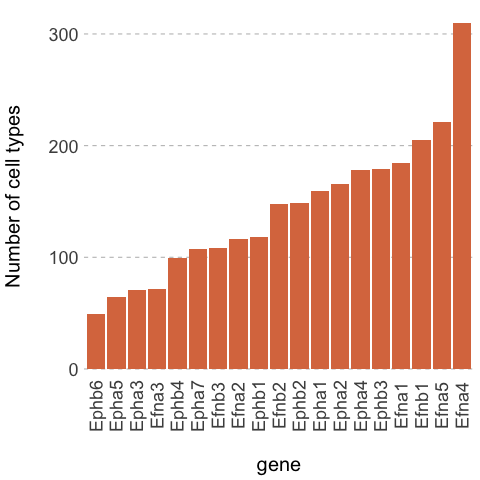

In [38]:
%%R -i notch_count_df
p <- ggplot(data = notch_count_df, aes(x = reorder(rownames(notch_count_df), counts), y = counts)) + 
     geom_hline(yintercept = 0, colour = "grey", linetype = "dashed") + 
     geom_hline(yintercept = 100, colour = "grey", linetype = "dashed") + 
     geom_hline(yintercept = 200, colour = "grey", linetype = "dashed") +
     geom_hline(yintercept = 300, colour = "grey", linetype = "dashed") +
     scale_y_continuous(breaks = seq(0, 300, 100), labels = c("0", "100", "200", "300"))+
     geom_bar(stat="identity", fill = "#DB784D") +
     labs(x = "gene", y = "Number of cell types") + 
     theme(axis.title.x = element_text(size = 20, margin = margin(t = 25)),
           axis.text.x = element_text(angle = 90, size = 18, vjust = 0.5, margin = margin(t = -10)), 
           axis.ticks.x = element_blank(),
           axis.title.y = element_text(size = 20, margin = margin(r = 25)),
           axis.text.y = element_text(size = 18),
           axis.ticks.y = element_blank(),
           panel.border = element_blank(), 
           panel.grid.major = element_blank(),
           panel.grid.minor = element_blank(), 
           panel.background = element_blank())
ggsave("./alejo_metadata/figures/own_norm/Figure_5_figure_supplement_3B_left.pdf")
p

### Co-Expression Heatmap of Ephrin

In [39]:
arrays = [
    np.repeat(pathway_genes, len(pathway_genes)),
    np.array(pathway_genes*len(pathway_genes))
]

coexp_df = pd.DataFrame(columns = arrays)

for i in pathway_genes:
    for j in pathway_genes:
        coexp_df[(i, j)] = np.where((notch_df[i] >= 0.2) & (notch_df[j] >= 0.2), 1, 0)
    
coexp_df = coexp_df.sum(axis = 0).unstack(level = 0)#.unstack().reset_index()

In [40]:
genes_order = ["Epha1", "Epha2", "Epha3", "Epha4", "Epha5", "Epha7", "Ephb1", "Ephb2", "Ephb3", "Ephb4", "Ephb6"] + ["Efna1", "Efna2", "Efna3", "Efna4", "Efna5", "Efnb1", "Efnb2", "Efnb3"]

coexp_df = coexp_df.loc[genes_order][genes_order]
coexp_df

,Epha1,Epha2,Epha3,Epha4,Epha5,Epha7,Ephb1,Ephb2,Ephb3,Ephb4,Ephb6,Efna1,Efna2,Efna3,Efna4,Efna5,Efnb1,Efnb2,Efnb3
Epha1,246,95,7,76,22,19,52,58,98,14,30,94,42,66,177,81,79,58,15
Epha2,95,234,12,86,3,25,68,28,84,73,28,136,26,20,71,72,123,110,8
Epha3,7,12,94,55,35,52,14,49,64,35,4,8,69,22,51,74,65,28,43
Epha4,76,86,55,269,57,103,92,126,127,104,14,98,117,58,182,142,154,125,99
Epha5,22,3,35,57,76,40,16,49,51,34,9,17,44,33,61,49,38,26,44
Epha7,19,25,52,103,40,150,52,90,77,52,7,26,85,26,107,104,87,54,89
Ephb1,52,68,14,92,16,52,175,69,58,50,7,47,56,10,108,65,101,64,55
Ephb2,58,28,49,126,49,90,69,221,147,59,10,56,114,41,169,148,121,63,109
Ephb3,98,84,64,127,51,77,58,147,270,65,37,85,101,57,167,176,140,87,86
Ephb4,14,73,35,104,34,52,50,59,65,163,8,101,54,24,60,72,118,115,44


In [41]:
%%R -i coexp_df

pheatmap(coexp_df, treeheight_row = 20,treeheight_col = 20,
         clustering_method = 'ward.D2', color = rev(colorRampPalette(rev(brewer.pal(n = 7, name ="Greys")))(100)),
         fontsize =12,angle_col = 45, cluster_rows = FALSE, cluster_cols = FALSE,
         #filename = paste(save_dir, pathway_name, '_Tissue_distribution_bmp.pdf'),
         filename = "./alejo_metadata/figures/own_norm/Figure_5_figure_supplement_3B_middle.pdf",
         breaks = seq(0, max(coexp_df), length.out = 100),
         height =4, width = 6)

## Wnt Receptors

In [42]:
pathway_genes = list(pathways[pathways["pathway"] == "Wnt"]["gene"].values)

In [43]:
x = integrated_counts[pathway_genes]
gene_quantiles = np.quantile(x, q= 0.99, axis = 0)
gene_quantiles

array([0.84933212, 0.86456011, 0.55207317, 0.55936017, 0.35093493,
       0.47195971, 0.41288929, 0.23695013, 0.24094939, 0.41982218,
       0.48585858, 0.68806374])

In [44]:
# saturated matrix  by 0.99 quantile to avoid problem with outliers in min.max 
x_clipped = quantile_saturation(x, gene_quantiles)
x_clipped.describe() 

,Fzd1,Fzd2,Fzd3,Fzd4,Fzd5,Fzd6,Fzd7,Fzd8,Fzd9,Fzd10,Lrp5,Lrp6
count,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000
mean,0.072044,0.147088,0.063665,0.054830,0.043207,0.044121,0.068572,0.032015,0.012256,0.028927,0.084144,0.176863
std,0.131776,0.226803,0.097499,0.106357,0.064917,0.091257,0.086896,0.048795,0.033232,0.070483,0.099900,0.144163
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.002275,0.000000,0.000765,0.001006,0.005678,0.000994,0.006335,0.000000,0.000000,0.000000,0.017946,0.066768
50%,0.026826,0.014881,0.025475,0.010813,0.016631,0.007595,0.032716,0.010705,0.001694,0.000569,0.051630,0.134056
75%,0.079249,0.231676,0.087851,0.051063,0.052708,0.030877,0.100439,0.039046,0.009486,0.019242,0.104989,0.249414
max,0.849332,0.864560,0.552073,0.559360,0.350935,0.471960,0.412889,0.236950,0.240949,0.419822,0.485859,0.688064


In [45]:
from sklearn.preprocessing import MinMaxScaler
# min max after saturation
scaler= MinMaxScaler() 
scaler.fit(x_clipped)
# max value for each gene = 1
df_clip = pd.DataFrame(scaler.transform(x_clipped), columns = pathway_genes)
df_clip['cell_id'] = integrated_counts['cell_id']
df_clip['Cell_class'] = integrated_counts['Cell_class']

In [46]:
df_clip['ON'] = np.sum(df_clip[pathway_genes].values>0.3, axis =1)>3

# pathway_mat is the final data.frame we are using 
pathway_mat = df_clip[df_clip['ON']]

In [47]:
df_clip.head()

,Fzd1,Fzd2,Fzd3,Fzd4,Fzd5,Fzd6,Fzd7,Fzd8,Fzd9,Fzd10,Lrp5,Lrp6,cell_id,Cell_class,ON
0,0.041848,0.465838,0.171300,0.009257,0.158750,0.030246,0.610857,0.100397,0.102840,0.152438,0.235286,0.430640,1_E6.5_8.5_Chan,Epiblast,False
1,0.000000,0.146973,0.091882,0.014462,0.018317,0.012796,0.123691,0.013136,0.022075,0.023829,0.062521,0.040691,2_E6.5_8.5_Chan,Ectoderm,False
2,0.016860,0.521482,0.113565,0.036922,0.137058,0.012377,0.813435,0.090470,0.052278,0.064421,0.310469,0.416074,3_E6.5_8.5_Chan,Epiblast,True
3,0.019803,0.534622,0.190433,0.024840,0.233882,0.061575,0.572637,0.099804,0.052574,0.004000,0.246419,0.368207,4_E6.5_8.5_Chan,Epiblast,False
4,0.118545,0.038033,0.092527,0.017741,0.070925,0.016887,0.270140,0.044095,0.083374,0.032273,0.225256,0.308255,5_E6.5_8.5_Chan,Ex_ectoderm,False


### Wnt

In [48]:
wnt_df = df_clip[pathway_genes]

wnt_count_df = pd.DataFrame((wnt_df > 0.3).apply(np.count_nonzero), columns = ["counts"])

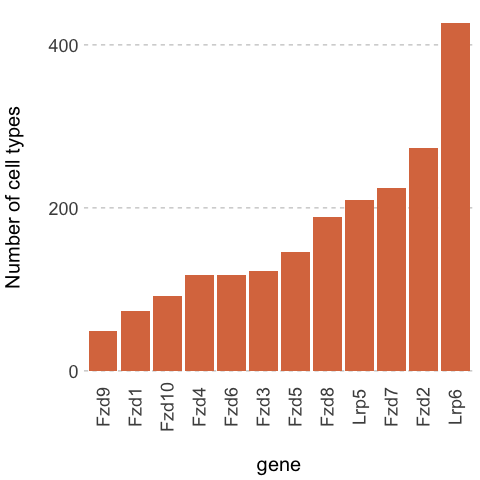

In [49]:
%%R -i wnt_count_df
p <- ggplot(data = wnt_count_df, aes(x = reorder(rownames(wnt_count_df), counts), y = counts)) + 
     geom_hline(yintercept = 0, colour = "grey", linetype = "dashed") + 
     geom_hline(yintercept = 200, colour = "grey", linetype = "dashed") + 
     geom_hline(yintercept = 400, colour = "grey", linetype = "dashed") +
     scale_y_continuous(breaks = seq(0, 400, 200), labels = c("0", "200", "400"))+
     geom_bar(stat="identity", fill = "#DB784D") +
     labs(x = "gene", y = "Number of cell types") + 
     theme(axis.title.x = element_text(size = 20, margin = margin(t = 25)),
           axis.text.x = element_text(angle = 90, size = 18, vjust = 0.5, margin = margin(t = -10)), 
           axis.ticks.x = element_blank(),
           axis.title.y = element_text(size = 20, margin = margin(r = 25)),
           axis.text.y = element_text(size = 18),
           axis.ticks.y = element_blank(),
           panel.border = element_blank(), 
           panel.grid.major = element_blank(),
           panel.grid.minor = element_blank(), 
           panel.background = element_blank())
ggsave("./alejo_metadata/figures/own_norm/Figure_5_figure_supplement_3C_left.pdf")
p

### Co-Expression Heatmap of Wnt Receptors

In [50]:
arrays = [
    np.repeat(pathway_genes, len(pathway_genes)),
    np.array(pathway_genes*len(pathway_genes))
]

coexp_df = pd.DataFrame(columns = arrays)

for i in pathway_genes:
    for j in pathway_genes:
        coexp_df[(i, j)] = np.where((wnt_df[i] >= 0.3) & (wnt_df[j] >= 0.3), 1, 0)
    
coexp_df = coexp_df.sum(axis = 0).unstack(level = 0)#.unstack().reset_index()

gene_order = natsorted(coexp_df.columns)

coexp_df = coexp_df.loc[gene_order][gene_order]

In [51]:
%%R -i coexp_df

pheatmap(coexp_df, treeheight_row = 20,treeheight_col = 20,
         clustering_method = 'ward.D2', color = rev(colorRampPalette(rev(brewer.pal(n = 7, name ="Greys")))(100)),
         fontsize =12,angle_col = 45, cluster_rows = FALSE, cluster_cols = FALSE,
         #filename = paste(save_dir, pathway_name, '_Tissue_distribution_bmp.pdf'),
         filename = "./alejo_metadata/figures/own_norm/Figure_5_figure_supplement_3C_middle.pdf",
         breaks = seq(0, max(coexp_df), length.out = 100),
         height =4, width = 6)